# 基于MindSpore实现Softmax
本实验基于mindspore平台实现对MNIST数据集的分类分析，并以分类的准确度和混淆矩阵为衡量指标，进行分类模型的的训练和预测。

## 1、实验目的

 (1)掌握softmax函数的基本原理。
 
 (2)使用MindSpore实现模型定义，进行分类模型的的训练和预测。

## 2、原理介绍
### softmax原理
Softmax函数是一种数学函数，它将一个数字向量转换为概率分布。它通常用于机器学习和深度学习的分类问题中。Softmax函数用于神经网络的输出层，将输出值转换为概率分布。输出值通过Softmax函数传递，将它们转换为概率。具有最高概率的类被视为预测类。

给定一个样本实例$x_{ij}$，softmax回归模型会先计算出每个类的分数$X_{ij}$，然后对这些分数应用softmax函数，估算出每个类的概率。
计算出每个类的分数，就可以通过softmax函数来评估实例属于类k的概率$\hat p_k$。函数分别计算每个分数的指数，然后对其进行归一化，也就是除以所有指数的总和。<br>
softmax函数：
$$\hat p_k = {softmax}(X_{j})=\frac{exp(X_{j})}{\Sigma_{k}{exp(X_{k})}}.$$
其中k是类数，$X_{j}$是一个向量，包含实例x的每个类的分数 ，j表示第j个分类，$\hat p_k$是实例x属于类k的估计概率，给定当前实例每个类的分数。<br>


## 3、实验环境
在动手进行实践之前，需要注意以下几点：
* 确保实验环境正确安装，包括安装MindSpore。安装过程：首先登录[MindSpore官网安装页面](https://www.mindspore.cn/install)，根据安装指南下载安装包及查询相关文档。同时，官网环境安装也可以按下表说明找到对应环境搭建文档链接，根据环境搭建手册配置对应的实验环境。
* 推荐使用交互式的计算环境Jupyter Notebook，其交互性强，易于可视化，适合频繁修改的数据分析实验环境。
* 实验也可以在华为云一站式的AI开发平台ModelArts上完成。
* 推荐实验环境：MindSpore版本=MindSpore 2.0；Python环境=3.7


|  硬件平台 |  操作系统  | 软件环境 | 开发环境 | 环境搭建链接 |
| :-----:| :----: | :----: |:----:   |:----:   |
| CPU | Windows-x64 | MindSpore2.0 Python3.7.5 | JupyterNotebook |[MindSpore环境搭建实验手册第二章2.1节和第三章3.1节](./MindSpore环境搭建实验手册.docx)|
| GPU CUDA 10.1|Linux-x86_64| MindSpore2.0 Python3.7.5 | JupyterNotebook |[MindSpore环境搭建实验手册第二章2.2节和第三章3.1节](./MindSpore环境搭建实验手册.docx)|
| Ascend 910  | Linux-x86_64| MindSpore2.0 Python3.7.5 | JupyterNotebook |[MindSpore环境搭建实验手册第四章](./MindSpore环境搭建实验手册.docx)|

## 4、数据处理
### 4.1 数据准备
MNIST数据集（Mixed National Institute of Standards and Technology Database）是一个用来训练各种图像处理系统的二进制图像数据集，广泛应用于机器学习中的训练和测试。 MNIST数据集共有70000张图像，其中训练集60000张，其中30000张来自NIST的Special Database 3，30000张来自NIST的Special Database 1。测试集10000张图像，其中5000张来自NIST的Special Database 3，5000张来自NIST的Special Database 1。每张图像都有标注，共10个类别，每个类别代表0~9之间的一个数字，每张图像只有一个类别，所有图像都是28×28的灰度图像，每张图像包含一个手写数字。

### 4.2 数据加载

MindSpore暂不支持直接加载的数据集，可以通过构造自定义数据集类或自定义数据集生成函数的方式来生成数据集，然后通过mindspore.dataset.GenaratorDataset接口实现自定义方式的数据集加载。 通过自定义数据集类和自定义数据集生成函数两种方式生成的数据集，都可以完成加载、迭代等操作。由于在自定义数据集类中定义了随机访问函数和获取数据集大小函数，因此当需要随机访问数据集中某条数据或获取数据集大小时，使用自定义数据集类生成的数据集可以快速完成这些操作，而通过自定义数据集生成函数的方式生成的数据集需要对数据逐条遍历方可完成这些操作。 一般情况下，当数据量较小时使用两种生成自定义数据集的方式中的任一种都可以，而当数据量过大时，优先使用自定义数据集类的方式生成数据集。

In [ ]:
def load_data_fashion_mnist(data_path, batch_size, resize=None, works=1):  
    #将Fashion-MNIST数据集加载到内存中。
    mnist_train = FashionMnist(data_path, kind='train')
    mnist_test = FashionMnist(data_path, kind='t10k')

    mnist_train = ds.GeneratorDataset(source=mnist_train, column_names=['image', 'label'], 
                                      shuffle=False,python_multiprocessing=False)
    mnist_test = ds.GeneratorDataset(source=mnist_test, column_names=['image', 'label'], 
                                     shuffle=False,python_multiprocessing=False)
    
    # 数据变换
    trans = [cv.Rescale(1.0 / 255.0, 0), cv.HWC2CHW()]   # 调整图像的像素大小Rescale变换用于调整图像像素值的大小，包括两个参数：
                                                         # rescale：缩放因子。shift：平移因子。图像的每个像素将根据这两个参数
                                                         # 进行调整，输出的像素值为outputi=inputi∗rescale+shift
                                                         # HWC2CWH变换用于转换图像格式，(height, width, channel)转为
                                                         # (channel, height, width)
    type_cast_op = C.TypeCast(mindspore.int32)           # 将输入的Tensor转换为指定的数据类型
    if resize:
        trans.insert(0, cv.Resize(resize))               # 调整为给定的尺寸大小
    mnist_train = mnist_train.map(trans, input_columns=["image"])
    mnist_test = mnist_test.map(trans, input_columns=["image"])
    mnist_train = mnist_train.map(type_cast_op, input_columns=['label'])
    mnist_test = mnist_test.map(type_cast_op, input_columns=['label'])
    
    mnist_train = mnist_train.batch(batch_size, num_parallel_workers=works)
    mnist_test = mnist_test.batch(batch_size, num_parallel_workers=works)
    
    return mnist_train, mnist_test

class FashionMnist():
    #创建一个迭代器类,作为GeneratorDataset的数据源
    def __init__(self, path, kind):  # 定义数据初始化等操作，在实例化数据集对象时被调用
        self.data, self.label = load_mnist(path, kind)
 
    def __getitem__(self, index):  # 定义该函数后可使其支持随机访问，能够根据给定的索引值index，获取数据集中的数据并返回
        return self.data[index], self.label[index]
 
    def __len__(self):  # 返回数据集的样本数量
        return len(self.data)

## 5、模型构建

nn. SequentialCell是一个有序的Cell容器，输入Tensor将按照定义的顺序通过所有Cell。 我们可以使用SequentialCell来快速组合构造一个神经网络模型。损失函数使用SoftmaxCrossEntropyWithLogits交叉熵损失函数，同时计算softmax及其损失。优化器采用随机梯度下降SGD，学习率指定为0.1。

导入Python库与模块，并配置运行信息

In [1]:
import mindspore #导入mindspore框架
import os#导入os对文件或文件夹操作
import struct#用于处理二进制数据。
import numpy as np#用于数值计算的扩展库
import mindspore.dataset as ds#数据集相关操作
from mindspore import nn #将Model用于创建模型对象，完成网络搭建和编译，并用于训练和评估
from mindspore.common.initializer import Normal#数据归一化
import mindspore.dataset.vision as cv#数据可视化
import mindspore.dataset.transforms as C#数据转换
from IPython import display#数据可视化
from matplotlib import pyplot as plt#导入绘图库

数据的读取

In [2]:
def load_mnist(path, kind='train'):
    #导入已下载的数据集，分别读取MNIST的标签数据和图像数据。  
    labels_path = os.path.join(path,'%s-labels-idx1-ubyte'% kind)#os.path.join()函数用于路径拼接文件路径
    images_path = os.path.join(path,'%s-images-idx3-ubyte'% kind)
    
    #标签数据的前8个字节是magic number和样本个数字段，所以标签数据的偏移量为8。 
    #使用struct.unpack方法读取前两个数据，lbpath.read(8)表示一次从文件中读取8个字节，这样读到的前两个数据分别是magic number（2049）和样本个数（60000），之后再读取标签数据。
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II',
                                 lbpath.read(8))
        labels = np.fromfile(lbpath,
                             dtype=np.uint8)
    
    #同样地，图像数据的前16个字节分别是magic number、图像数量、图像的高rows和图像的宽columns。 
    #使用struct.unpack方法读取前四个数据，lbpath.read(16)表示一次从文件中读取16个字节，这样读到的前四个数据分别是magic number（2051）、图像数量（60000）、图像的高rows（28）和图像的宽columns（28）。
    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII',
                                               imgpath.read(16))
        images = np.fromfile(imgpath,
                             dtype=np.uint8).reshape(len(labels),28,28,1)   # 设置图像形状，高度宽度均为28，通道数为1

    return images, labels

数据的加载

In [3]:
def load_data_fashion_mnist(data_path, batch_size, resize=None, works=1):  
    #将Fashion-MNIST数据集加载到内存中。
    mnist_train = FashionMnist(data_path, kind='train')
    mnist_test = FashionMnist(data_path, kind='t10k')

    mnist_train = ds.GeneratorDataset(source=mnist_train, column_names=['image', 'label'], 
                                      shuffle=False,python_multiprocessing=False)
    mnist_test = ds.GeneratorDataset(source=mnist_test, column_names=['image', 'label'], 
                                     shuffle=False,python_multiprocessing=False)
    
    # 数据变换
    trans = [cv.Rescale(1.0 / 255.0, 0), cv.HWC2CHW()]   # 调整图像的像素大小Rescale变换用于调整图像像素值的大小，包括两个参数：
                                                         # rescale：缩放因子。shift：平移因子。图像的每个像素将根据这两个参数
                                                         # 进行调整，输出的像素值为outputi=inputi∗rescale+shift
                                                         # HWC2CWH变换用于转换图像格式，(height, width, channel)转为
                                                         # (channel, height, width)
    type_cast_op = C.TypeCast(mindspore.int32)           # 将输入的Tensor转换为指定的数据类型
    if resize:
        trans.insert(0, cv.Resize(resize))               # 调整为给定的尺寸大小
    mnist_train = mnist_train.map(trans, input_columns=["image"])
    mnist_test = mnist_test.map(trans, input_columns=["image"])
    mnist_train = mnist_train.map(type_cast_op, input_columns=['label'])
    mnist_test = mnist_test.map(type_cast_op, input_columns=['label'])
    
    mnist_train = mnist_train.batch(batch_size, num_parallel_workers=works)
    mnist_test = mnist_test.batch(batch_size, num_parallel_workers=works)
    
    return mnist_train, mnist_test

class FashionMnist():
    def __init__(self, path, kind):  # 定义数据初始化等操作，在实例化数据集对象时被调用
        self.data, self.label = load_mnist(path, kind)
 
    def __getitem__(self, index):  # 定义该函数后可使其支持随机访问，能够根据给定的索引值index，获取数据集中的数据并返回
        return self.data[index], self.label[index]
 
    def __len__(self):  # 返回数据集的样本数量
        return len(self.data)

batch_size = 256
mnist_train, mnist_test = load_data_fashion_mnist('MNIST/' ,batch_size)

定义模型

In [4]:
# nn.SequentialCell是一个有序的Cell容器。输入Tensor将按照定义的顺序通过所有Cell
# 我们可以使用SequentialCell来快速组合构造一个神经网络模型
net = nn.SequentialCell([nn.Flatten(), nn.Dense(784, 10, weight_init=Normal(0.01, 0), bias_init='zero')])
# nn.Flatten将输入的X维度从[256,1,28,28]变成[256,784]，则一个样本数据一行
 
# 损失函数SoftmaxCrossEntropyWithLogits，交叉熵损失函数中传递未规范化的预测，并同时计算softmax及其损失
loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')

# 优化器SGD，学习率为0.1的随机梯度下降
optim = nn.SGD(net.trainable_params(), learning_rate=0.1)

## 6、模型训练

指定迭代次数num_epochs，输入到训练器trainer中，进行模型的训练。

In [5]:
class Accumulator:  
   #定义累加器
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
def train_epoch(net, train_iter, loss, optim):  
    #训练模型一个迭代周期
    net_with_loss = nn.WithLossCell(net, loss)                # 将net与loss连接
    net_train = nn.TrainOneStepCell(net_with_loss, optim)     # 将net,loss,optim连接,生成训练模型
    metric = Accumulator(3)
    for X, y in train_iter:
        l = net_train(X, y)
        y_hat = net(X)
        metric.add(float(l.sum().asnumpy()), accuracy(y_hat, y), y.size)
    return metric[0] / metric[2], metric[1] / metric[2]       # 误差 / 预测总数 ，正确预测数 / 预测总数

def trainer(net, train_iter, test_iter, loss, num_epochs, optim):  
    #训练模型
    # 动画设置
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    
    for epoch in range(num_epochs):
        train_metrics = train_epoch(net, train_iter, loss, optim)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    
    # 检测
    assert train_loss < 0.6, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

## 7、模型预测

使用混淆矩阵和精确度评估，动态可视化模型结果。

In [6]:
# 绘制混淆矩阵
classes = ['0', '1', '2', '3', '4', '5','6','7','8','9']
def plot_confusion_matrix(cm, title='Confusion Matrix'):
    plt.figure(figsize=(12, 8), dpi=100)
    np.set_printoptions(precision=2)
    # 混淆矩阵中每格的值
    ind_array = np.arange(len(classes))
    x, y = np.meshgrid(ind_array, ind_array)
    for x_val, y_val in zip(x.flatten(), y.flatten()):
        c = cm[y_val][x_val]
        if c > 0.001:
            plt.text(x_val, y_val, "%0.2f" % (c,), color='#EE3B3B', fontsize=10, va='center', ha='center')
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.binary)
    plt.title(title)
    plt.colorbar()
    xlocations = np.array(range(len(classes)))
    plt.xticks(xlocations, classes, rotation=90)
    plt.yticks(xlocations, classes)
    plt.ylabel('Actual Label')
    plt.xlabel('Predict Label')
    tick_marks = np.array(range(len(classes))) + 0.5
    plt.gca().set_xticks(tick_marks, minor=True)
    plt.gca().set_yticks(tick_marks, minor=True)
    plt.gca().xaxis.set_ticks_position('none')
    plt.gca().yaxis.set_ticks_position('none')
    plt.grid(True, which='minor', linestyle='-')
    plt.gcf().subplots_adjust(bottom=0.15)
    plt.show()

In [7]:
def accuracy(y_hat, y):  
    #计算预测正确的数量
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:   # 判断y_hat是不是矩阵
        y_hat = y_hat.argmax(axis=1)                  # 得到每样本预测概率最大所属分类的下标
    cmp = y_hat.asnumpy() == y.asnumpy()              # y_hat.asnumpy() == y.asnumpy()返回的是一个布尔数组
    return float(cmp.sum())

In [8]:
def evaluate_accuracy(net, data_iter):  
    #计算在指定数据集上模型的精度
    metric = Accumulator(2)         # 累加器,metric[0]记录正确预测数，metric[1]记录预测总数
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), y.size)
    return metric[0] / metric[1]    # 正确预测数 / 预测总数

In [9]:
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    #设置matplotlib的轴
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

class Animator:  
   #在动画中绘制数据
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        if legend is None:
            legend = []
        display.set_matplotlib_formats('svg')
        self.fig, self.axes =plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

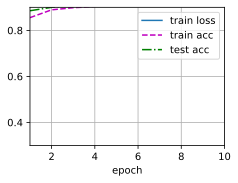

In [10]:
num_epochs = 10
trainer(net, mnist_train, mnist_test, loss, num_epochs, optim)
plt.show()